In [1]:
# Celda 1: Imports y parámetros y argparse para variables desde terminal
import numpy as np                      # Celdas: 2,3,4,5,6,7,8 (NP arrays, random choice with rng)
import matplotlib.pyplot as plt         # Celdas: 2,6,7,8 (Visualización, gráficos, animación)
import time                             # Celda: 5 (Medición de tiempos)
from tqdm import tqdm                   # Celda: 5 (Barra de progreso, opcional)
import argparse                         # Celdas: 1 (parseo de argumentos)
import sys                              # Para obtener argv en parse_known_args

# ─── Funciones de validación de argumentos ─────────────────────────────────
def positive_int(value):
    try:
        iv = int(value)
    except ValueError:
        raise argparse.ArgumentTypeError(f"Valor inválido para argumento entero: '{value}'")
    if iv <= 0:
        raise argparse.ArgumentTypeError(f"El valor debe ser un entero positivo: {iv}")
    return iv

# ─── Análisis de argumentos (compatibilidad Jupyter) ──────────────────────────
parser = argparse.ArgumentParser(
    description='Simulación Monte Carlo de Ising 2D con dinámica de Kawasaki')
parser.add_argument('--L',       type=positive_int, default=25,    help='Tamaño de la red LxL (entero positivo)')
parser.add_argument('--J',       type=float,       default=1.0,   help='Constante de acoplamiento')
parser.add_argument('--T',       type=float,       default=2.269, help='Temperatura (k_B=1)')
parser.add_argument('--n_sweeps',type=positive_int, default=1000,  help='Número de barridos Monte Carlo (entero positivo)')
parser.add_argument('--seed',    type=int,         default=None,  help='Semilla para RNG (None: entropía)')
# parse_known_args ignora flags desconocidos (como los de Jupyter)
args, _ = parser.parse_known_args(sys.argv[1:])

# ─── Parámetros del modelo ────────────────────────────────────────────────────
L        = args.L
J        = args.J
T        = args.T
n_sweeps = args.n_sweeps

# ─── Configuración de semilla para reproducibilidad ──────────────────────────
seed = args.seed                       # None = usar entropía del sistema
rng  = np.random.default_rng(seed)     # PCG64 RNG: seguro y adecuado para simulaciones


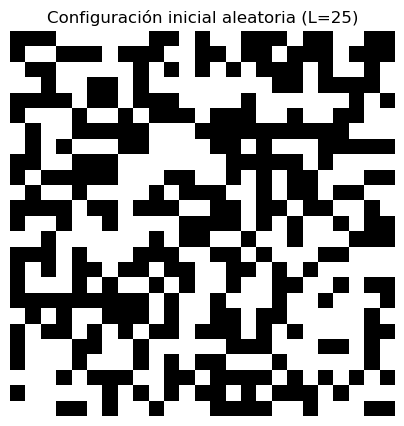

In [53]:
# ─── Celda 2: Inicialización de la red y visualización ───────────────────────
# Generar configuración inicial aleatoria de espines ±1
def init_config(L, rng):
    """
    Crea una matriz L×L de espines aleatorios ±1 usando el RNG proporcionado.
    """
    return rng.choice([1, -1], size=(L, L))

# Crear configuración y mostrarla
config = init_config(L, rng)
plt.figure(figsize=(5,5))
plt.imshow(config, cmap='gray', interpolation='nearest')
plt.title(f'Configuración inicial aleatoria (L={L})')
plt.axis('off')
plt.show()


In [59]:
# ─── Celda 3: Definición de observables termodinámicos ─────────────────────

def energy(config, J=J):
    """
    Calcula la energía total del modelo de Ising 2D con contorno periódico.
    """
    # Enlaces derecha e inferior para contar cada par una sola vez
    right = np.roll(config, -1, axis=1)
    down  = np.roll(config, -1, axis=0)
    return -J * np.sum(config * (right + down))


def magnetization(config):
    """
    Calcula la magnetización total del sistema.
    """
    return np.sum(config)

# Ejemplo de uso en Celda 3
E0 = energy(config)
M0 = magnetization(config)
print(f"Energía inicial: {E0:.2f}, Magnetización inicial: {M0}")


Energía inicial: 50.00, Magnetización inicial: 17


In [64]:
# ─── Celda 4: Generación de Matriz de selección de vecino y cálculo de ΔE para Kawasaki ──────────────

def RandomMatrixGeneration(L, rng):
    """
    Genera una matriz con enteros aleatorios entre 0 y 3, de forma que cada vez que llamemos a la función generamos una destribucción
    de selección de pares aleatoria, única en cada sweep.
    """
    # Generar una matriz de enteros aleatorios entre 0 y 3
    return rng.integers(0, 4, size=(L, L))

def delta_E_kawasaki(config, i, j, k, l, J=J):
    """
    Calcula el cambio de energía ΔE para un intercambio de espines en la dinámica de Kawasaki.
    """
    #Tomamos variable auxiliar para el cálculo de la energía
    # de la configuración inicial y de la configuración final
    Aux_1 = config[i,j]
    Aux_2 = config[k,l]
    #Calculamos la energía de la configuración inicial
    E_1 = -J*(Aux_1*(config[i,j-1] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L])+Aux_2*(config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L]))
    #Ahora intercambiamos el valor de las variables auxiliares
    Aux_1 = config[k,l]
    Aux_2 = config[i,j]
    #Calculamos la energía de la configuración final
    E_2 = -J*(Aux_1*(config[i,j-1] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L])+Aux_2*(config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L]))
    #Calculamos el cambio de energía
    delta_E = E_2 - E_1
    return delta_E



In [65]:
# ─── Celda 5: Bucle Monte Carlo y recolección de datos ────────────────────────
# Inicializar arrays para almacenar energía y magnetización
energies = np.zeros(n_sweeps + 1)
magnetizations = np.zeros(n_sweeps + 1)

# Medir estado inicial
energies[0] = energy(config, J)
magnetizations[0] = magnetization(config)

# Barrido Monte Carlo
start_time = time.time()
for sweep in tqdm(range(1, n_sweeps + 1), desc='MC Sweeps'): #Esto es una simple barra de progreso, nada más
    #Ahora vamos a barrer la red completa, y en cada interacción vamos a elegir un vecino, fijando así el par a intercambiar.
    #Lo primero es generar la matriz de enteros aleatorios entre 0 y 3 para elegir el par de espines a intercambiar
    RandomMatrix = RandomMatrixGeneration(L, rng)
    #Ahora calculamos las coordenadas de los espines a intercambiar mediante un vector de offsets
    offsets = [(0, 1), (0, -1), (1, 0), (-1, 0)] #Al sumar el offset a la posición del espín, obtenemos la posición del espín vecino
    #ya que la matriz aleatoria contiene los índices del offset (el desplazamiento).
    #Ahora podemos barrer la red para elegir el par de espines a intercambiar.
    for i in range (L):
        for j in range (L):
            #Primero tomamos el índice de la matriz aleatoria en posición (i,j)
            d = RandomMatrix[i,j]
            #Ahora tomamos el offset correspondiente al índice (di, dj)
            di, dj = offsets[d]
            #Ahora podemos calcular la posición exacta del espín vecino
            ni, nj = (i + di) % L, (j + dj) % L
            #Ahora que tenemos la posición del espín vecino, podemos calcular el ΔE
            delta_E = delta_E_kawasaki(config, i, j, ni, nj, J)
            #Ahora que tenemos el ΔE, podemos decidir si aceptamos o no el movimiento
            #La condición básicamente es que para ΔE <= 0, aceptamos el movimiento, ya que de ser así la probabilidad de aceptación es 1.
            #Si ΔE > 0, aceptamos el movimiento con probabilidad p = exp(-ΔE/T), y lo más eficiente es generar un número aleatorio entre 0 y 1 y comparar con p, 
            #ya que si el número aleatorio es menor o igual que p, aceptamos el movimiento.
            if delta_E <= 0 or rng.random() < np.exp(- delta_E/T):
                # Intercambiar espines
                config[i, j], config[ni, nj] = config[ni, nj], config[i, j]
    # Registrar observables
    energies[sweep] = energy(config, J)
    magnetizations[sweep] = magnetization(config)
end_time = time.time()

print(f"Simulación completada en {end_time - start_time:.2f} s")

MC Sweeps: 100%|██████████| 1000/1000 [00:04<00:00, 202.75it/s]

Simulación completada en 4.94 s
